# Coursera

##   AI for Medicine Specialization

###     AI for Medical Diagnosis

####       Week 2

# Densenet

Densenet is a convolutional network where each layer is connected to all other layers that are deeper in the network
- The first layer is connected to the 3rd, 4th etc.
- The second layer is connected to the 3rd, 4th, 5th etc.

Like this:

<img src="../../imgs/densenet.png" alt="U-net Image" width="400" align="middle"/>

For a detailed explanation of Densenet, check out the source of the image above, a paper by Gao Huang et al. 2018 called [Densely Connected Convolutional Networks](https://arxiv.org/pdf/1608.06993.pdf).

#### The classwork was developed for a the v1 version of tensorflow; I have rewritten it to accomodate the v2 version of tensorflow, and while I was at it, I reworked the whole thing to improve my understanding

#### In addition, the valid-small.csv had only one image in images-small/. So I extracted the rest using 'Pull the missing images in valid-small.ipynb'

In [1]:
import os
import pytz
import random
import sklearn
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pprint import pprint
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [2]:
tf.__version__

'2.17.0'

In [3]:
# Set the seed for reproducibility
random_state=42

random.seed(random_state)
np.random.seed(random_state)
tf.random.set_seed(random_state)

In [4]:
# this accomodates Google colab and my personal Mac Book Pro

data_dir  = "../../data/nih/"

try:
  from google.colab import drive
  drive.mount('/content/drive')
  !cp -r "/content/drive/MyDrive/machine learning/Coursera Medical XRays" /content/

  data_dir  = '/content/Coursera Medical XRays/data/nih/'
  os.chdir('/content/drive/MyDrive/machine learning/Coursera Medical XRays/AI for Medical Diagnosis/Week 1')
except:
  pass

In [5]:
!pwd

/home/ec2-user/machine_learning/Coursera AI for Medicine Specialization/AI for Medical Diagnosis/Week 2


# Global-use variables

In [6]:
# image-dimesions to use in the neural net
target_w, target_h = 320, 320

# number of batches to use in the neural net
batch_size         = 64

learning_rate      = 1e-4

# Load and prepare the data

## (1024, 1024, 3) x-rays and length-14 arrays of 1s and 0s indicating diseases

In [7]:
image_dir = data_dir + "images-small/"

train_csv = data_dir + "train-small.csv"
valid_csv = data_dir + "valid-small.csv"
test_csv  = data_dir + "test.csv"

## Create text labels

In [8]:
train_df = pd.read_csv(train_csv)
valid_df = pd.read_csv(valid_csv)
test_df  = pd.read_csv(test_csv)

labels_text = list(train_df.drop(['Image','PatientId'], axis=1).columns)
pprint(labels_text)

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']


## Check for NaNs

In [9]:
def check_nans_in_dataframe(df):
    # Check for NaN values in each column
    nan_summary = df.isnull().sum()
    
    # Filter to only show columns that have NaN values
    nan_summary = nan_summary[nan_summary > 0].sort_values(ascending=False)
    
    # Create a DataFrame to display the result in a tabular form
    nan_report = pd.DataFrame({
        'Column': nan_summary.index,
        'Num_NaNs': nan_summary.values
    })
    
    if nan_report.empty:
        print("No NaN values found in the DataFrame.")
    else:
        display(nan_report)  # Displays the DataFrame in a Jupyter Notebook, or you can use print(nan_report)
        
    return nan_report

# Example usage with your DataFrame
# df = pd.read_csv('your_file.csv')  # Example of loading data
nan_report = check_nans_in_dataframe(train_df)
nan_report = check_nans_in_dataframe(valid_df)
nan_report = check_nans_in_dataframe(test_df)

No NaN values found in the DataFrame.
No NaN values found in the DataFrame.
No NaN values found in the DataFrame.


In [10]:
train_df.head(1)

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0


## Keep PatientId unique among train_df, valid__df and test_df

In [11]:
# Assume train_df, valid_df, and test_df all have a column 'PatientId'

print(f"df sizes before removal {train_df.shape = } {valid_df.shape = } {test_df.shape = }")

# Step 1: Remove rows from train_df where 'PatientId' exists in valid_df or test_df
train_df = train_df[~train_df['PatientId'].isin(valid_df['PatientId'])]
train_df = train_df[~train_df['PatientId'].isin(test_df['PatientId'])]

# Step 2: Remove rows from valid_df where 'PatientId' exists in test_df
valid_df = valid_df[~valid_df['PatientId'].isin(test_df['PatientId'])]

print(f"df sizes  after removal {train_df.shape = }  {valid_df.shape = } {test_df.shape = }")

# Now, train_df and valid_df should no longer contain 'PatientId' values that overlap with valid_df or test_df.

df sizes before removal train_df.shape = (1000, 16) valid_df.shape = (109, 16) test_df.shape = (420, 16)
df sizes  after removal train_df.shape = (989, 16)  valid_df.shape = (109, 16) test_df.shape = (420, 16)


## Create datasets in Numpy

In [12]:
for i in range(1):
    image = tf.keras.preprocessing.image.load_img(os.path.join(image_dir, train_df['Image'].iloc[i]))
    image = tf.keras.preprocessing.image.img_to_array(image)

image.shape

(1024, 1024, 3)

In [13]:
X_train = []

for i in range(len(train_df['Image'])):
    image = tf.keras.preprocessing.image.load_img(os.path.join(image_dir, train_df['Image'].iloc[i]), target_size=(target_w, target_h))
    image = tf.keras.preprocessing.image.img_to_array(image)
    X_train.append(image)

X_train = np.array(X_train).astype(np.float32)

y_train = train_df[labels_text].values.astype(np.int32)  # Get the multi-label output

# ----------------

X_valid = []
for i in range(len(valid_df['Image'])):
    image = tf.keras.preprocessing.image.load_img(os.path.join(image_dir, valid_df['Image'].iloc[i]), target_size=(target_w, target_h))
    image = tf.keras.preprocessing.image.img_to_array(image)
    X_valid.append(image)

X_valid = np.array(X_valid).astype(np.float32)

y_valid = valid_df[labels_text].values.astype(np.int32)  # Get the multi-label output

# ----------------

X_test = []

for i in range(len(test_df['Image'])):
    image = tf.keras.preprocessing.image.load_img(os.path.join(image_dir, train_df['Image'].iloc[i]), target_size=(target_w, target_h))
    image = tf.keras.preprocessing.image.img_to_array(image)
    X_test.append(image)

X_test = np.array(X_test).astype(np.float32)

y_test = test_df[labels_text].values.astype(np.int32)  # Get the multi-label output

print(f"{X_train.shape = } {X_valid.shape = } {X_test.shape = }")
print(f"{y_train.shape = }          {y_valid.shape = }          {y_test.shape = }")

X_train.shape = (989, 320, 320, 3) X_valid.shape = (109, 320, 320, 3) X_test.shape = (420, 320, 320, 3)
y_train.shape = (989, 14)          y_valid.shape = (109, 14)          y_test.shape = (420, 14)


# Convert to tensors

In [14]:
train_tf = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_tf = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_tf  = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Cache the datasets (to avoid redundant operations in future epochs)
train_tf = train_tf.cache()
valid_tf = valid_tf.cache()
test_tf  = test_tf.cache()

# Shuffle the train dataset
train_tf = train_tf.shuffle(buffer_size=1024)  # Shuffle only the training data

# from tensorflow_utils import combine_features
# # Map the combine_features function
# train_tf = train_tf.map(lambda x, y: (combine_features(x), y), num_parallel_calls=tf.data.AUTOTUNE)
# valid_tf = valid_tf.map(lambda x, y: (combine_features(x), y), num_parallel_calls=tf.data.AUTOTUNE)
# test_tf  = test_tf.map(lambda x, y:  (combine_features(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# Batch, prefetch for efficient processing
train_tf = train_tf.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_tf = valid_tf.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_tf  = test_tf.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

2024-10-23 16:47:19.695468: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20750 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:36:00.0, compute capability: 8.9


In [15]:
# Verify the shapes of the features and labels in the combined dataset
print("\nFor train_dataset")
for feature_batch, label_batch in train_tf.take(1):
    print(f"Combined Feature Batch Shape (batch size, width, height, layers): {feature_batch.shape}")
    print(f"Label Batch Shape            (batch size, number of classes):     {label_batch.shape}")


For train_dataset
Combined Feature Batch Shape (batch size, width, height, layers): (64, 320, 320, 3)
Label Batch Shape            (batch size, number of classes):     (64, 14)


2024-10-23 16:47:23.281965: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Data Visualization


np.min((X_train/255.0)) = 0.0
np.max((X_train/255.0)) = 1.0
X_train.shape = (989, 320, 320, 3)


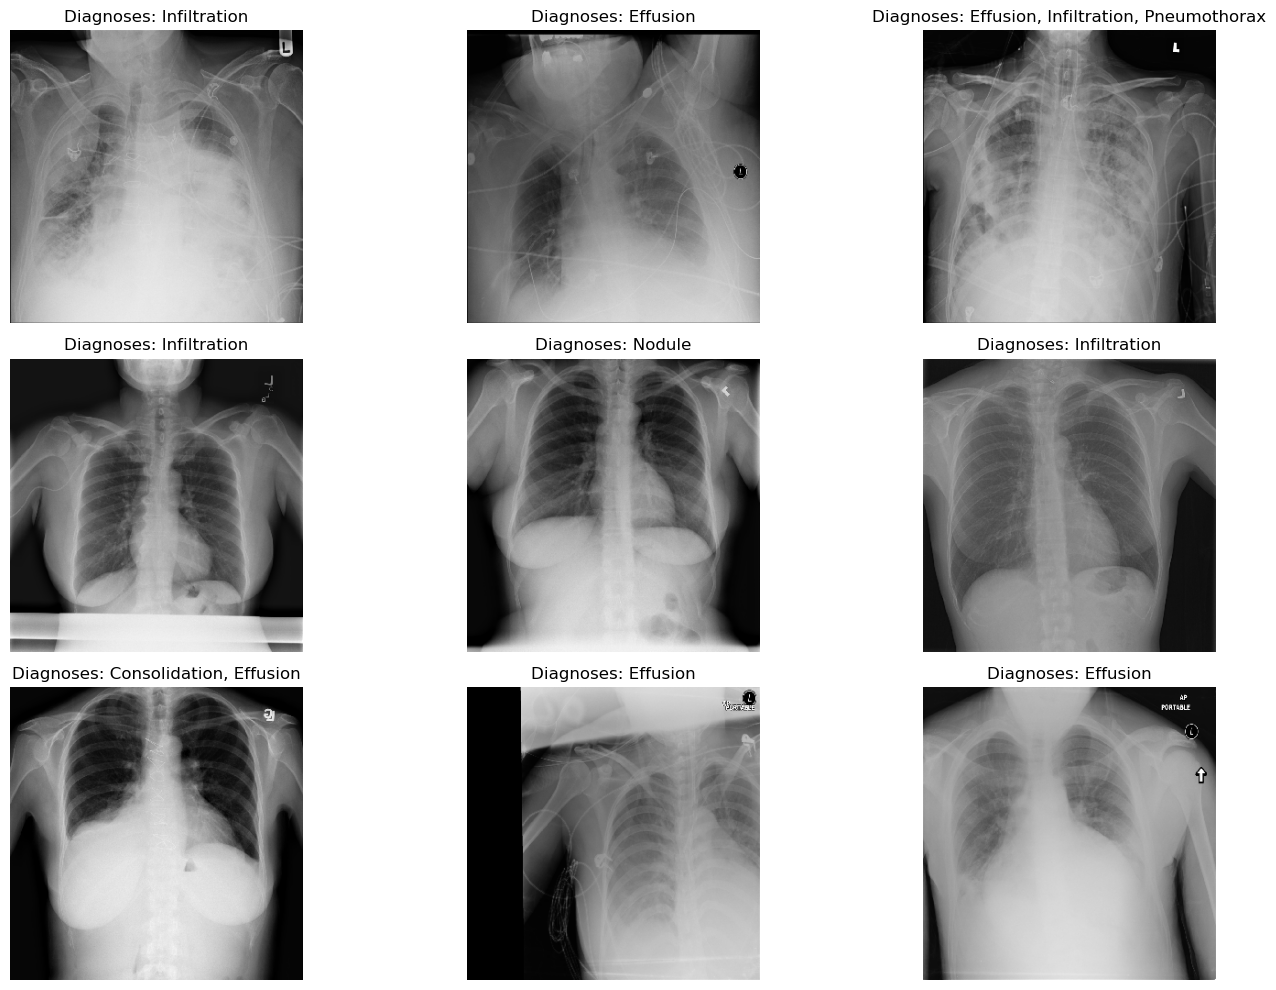

In [16]:
def shuffled_list(n):
  '''Creates a shuffled list of integers from 0 to n-1'''
  lst = list(range(n))  # Create a list from 0 to n
  random.shuffle(lst)   # Shuffle the list in place
  return lst

def display_images_with_diseases(X_train, y_train, labels_text, normalized=False):
    """
    Displays a 3x3 grid of images from `X_train` with their corresponding diagnoses (diseases).

    This function selects up to 9 images from `X_train` that have at least one associated disease (i.e., the 
    corresponding entry in `y_train` has a value of 1 for at least one label). For each selected image, the 
    corresponding diagnoses (from `labels_text`) are displayed as the title. Images are displayed in a 
    3x3 grid using Matplotlib.

    Args:
    X_train (np.array): A numpy array of training images, typically of shape (num_samples, height, width, channels).
                        The images are expected to be grayscale (single channel).
    y_train (np.array): A numpy array of binary labels with shape (num_samples, num_classes), where each element is 
                        0 or 1, indicating the absence or presence of the corresponding disease.
    labels_text (list): A list of text labels corresponding to the disease categories, with length equal to `num_classes`.
                        Each label describes a disease, such as ['Disease_1', 'Disease_2', ...].
    normalized (bool, optional): Whether the images in `X_train` are normalized (i.e., scaled to the range [0, 1]).
                                 If True, the images will be scaled back to the [0, 255] range for display.
                                 Default is False.

    Returns:
    None: The function displays a grid of images with their diagnoses using Matplotlib and does not return any value.

    Function Details:
    - The function uses a helper function `shuffled_list(n)` to shuffle the indices of the images to ensure random selection.
    - Only images with at least one positive diagnosis (i.e., at least one '1' in `y_train`) are displayed.
    - The function scales the images back to the [0, 255] range if they were normalized and converts them to `uint8` for proper display.
    - Each image is displayed along with its corresponding diagnoses in a 3x3 grid.
    - The function stops after displaying 9 images, ensuring the grid layout is maintained.

    Example Usage:
    ```python
    display_images_with_diseases(X_train, y_train, labels_text, normalized=True)
    ```

    """
    num_imgs = 0
    plt.figure(figsize=(15, 10))  # 15 units wide, 10 units tall

    for i in shuffled_list(X_train.shape[0]):
        if num_imgs >= 9:
            break

        # Find images with at least one disease (at least one '1' in the label)
        if np.sum(y_train[i]) > 0:
            num_imgs += 1

            # Scale image back to [0, 255] if it's normalized
            img = X_train[i] * 255.0 if normalized else X_train[i]

            # Convert to integer for display if necessary
            img = img.astype(np.uint8)

            # Get the diagnosis for this image
            diagnoses = [labels_text[j] for j in range(len(y_train[i])) if y_train[i][j] == 1]
            title_text = f"Diagnoses: {', '.join(diagnoses)}"

            plt.subplot(3, 3, num_imgs)  # Change to num_imgs to keep it within 1-9
            plt.imshow(img, cmap='gray')  # Assuming grayscale X-ray images
            plt.title(title_text)
            plt.axis('off')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# For normalized images in the range [0, 1]
print(f"\n{np.min((X_train/255.0)) = }\n{np.max((X_train/255.0)) = }")
print(f"{X_train.shape = }")
display_images_with_diseases(X_train / 255.0, y_train, labels_text, normalized=True)

# Build a DenseNet121 with Keras's Functional API

In [17]:
# -------------------------------------------------------------------------
inputs = tf.keras.layers.Input(shape=(target_h, target_w, 3))

x = tf.keras.layers.RandomBrightness(0.1)(inputs)
x = tf.keras.layers.RandomContrast(0.1)(x)

# Resize and normalize pixel values
x = tf.keras.layers.Resizing(target_h, target_w)(x)

# -------------------------------------------------------------------------

# Calculate the mean and std for the entire dataset
mean = np.mean(X_train, axis=(0, 1, 2))   # Mean over height, width, and all samples
std  = np.std(X_train,  axis=(0, 1, 2))   # Standard deviation over height, width, and all samples

def custom_densenet_preprocessing(input_tensor):
    '''
    tf.keras.applications.densenet.preprocess_input
    is specific to imagenet
       
    this function creates preprocessing specific to our training set of xrays
    '''
    return (input_tensor - mean) / std

x = tf.keras.layers.Lambda(custom_densenet_preprocessing)(x)

# -------------------------------------------------------------------------

base_model = tf.keras.applications.DenseNet121(weights='../../models/nih/densenet.hdf5', include_top=False)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Unfreezing the last layers of the base model makes validation divergence worse

x = base_model(x)

# -------------------------------------------------------------------------

x = tf.keras.layers.GlobalAveragePooling2D()(x)
# Flatten makes things worse

x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dropout(0.2)(x)

# -------------------------------------------------------------------------

# Output layer
outputs = tf.keras.layers.Dense(14, activation='sigmoid')((x))

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness               │ (None, 320, 320, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 320, 320, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 10, 10, 1024)   │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 14)             │           462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,105,646 (27.11 MB)

 Trainable params: 68,142 (266.18 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

# Calculate Class Weights and Loss Functions

Calculate the two terms that make up the loss function.  Notice that you are working with more than one class (represented by columns).  In this case, there are two classes.

Start by calculating the loss for class `0`.

$$ loss^{(i)} = loss_{pos}^{(i)} + los_{neg}^{(i)} $$

$$loss_{pos}^{(i)} = -1 \times weight_{pos}^{(i)} \times y^{(i)} \times log(\hat{y}^{(i)})$$

$$loss_{neg}^{(i)} = -1 \times weight_{neg}^{(i)} \times (1- y^{(i)}) \times log(1 - \hat{y}^{(i)})$$

In [19]:
"""
This section calculates class weights for each label, computes sample weights, and sets up a TensorFlow dataset
to be used in the `model.fit()` function with weighted binary cross-entropy loss.

Steps:
1. **Class Weights Calculation**:
    - Class weights are computed for each label (0 to 13) using `sklearn.utils.class_weight.compute_class_weight`.
    - These weights are designed to handle class imbalance by giving higher weights to underrepresented classes (where `y=1`).
    - For each label:
      - The first value in the tuple corresponds to the weight for the negative class (`y=0`).
      - The second value corresponds to the weight for the positive class (`y=1`).

2. **Class Weights Representation**:
    - Class weights are converted to a human-readable format using a pandas DataFrame for easy inspection and verification.
    - The `weighted_binary_crossentropy_weights` DataFrame contains the weights for each label in a two-column format (`negative`, `positive`).

3. **Sample Weights Calculation**:
    - Sample weights are calculated for each sample in the training data (`y_train`).
    - The sample weights for each label are based on the class weights. Samples with `y=1` for a label are given the positive class weight, 
      while those with `y=0` are given the negative class weight.
    - After calculating the sample weights for each label, the weights are averaged across all labels to create a single weight for each sample.

4. **Prepare TensorFlow Dataset for Training**:
    - The training data (`X_train`, `y_train`) and the computed sample weights are converted into a TensorFlow dataset.
    - The dataset is cached for performance optimization, shuffled to introduce randomness during training, batched, and prefetched to optimize data loading.

Key Variables:
- `class_weights`: A dictionary containing weights for each label (0 to 13), with the negative and positive class weights.
- `class_weights_with_labels`: A dictionary mapping human-readable label names to their corresponding class weights.
- `weighted_binary_crossentropy_weights`: A pandas DataFrame representing class weights in a two-column format (`negative`, `positive`).
- `sample_weights`: A numpy array of sample weights, where each sample is assigned a weight based on the class imbalance across labels.
- `train_tf_with_weights`: A TensorFlow dataset that combines the training data (`X_train`, `y_train`) and the calculated sample weights.
"""

# Assuming y_train is your training label data with shape (samples, 14)
class_weights = {}

# Calculate class weights for each class (0 to 13)
for i in range(14):
    class_weights[i] = sklearn.utils.class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train[:, i]),
        y=y_train[:, i]
    )

# First value corresponds to the weight for class 0 (negative class, indicating absence of the label).
# Second value corresponds to the weight for class 1 (positive class, indicating presence of the label)

class_weights_with_labels            = {labels_text[key]: value for key, value in class_weights.items()}
weighted_binary_crossentropy_weights = pd.DataFrame(class_weights_with_labels, index=['negative', 'positive']).T

# Sample weights calculation (for each sample, based on the class weights)
# shape of y_train: (num_samples, 14)
sample_weights = np.ones_like(y_train, dtype=np.float32)

for i in range(14):
    sample_weights[:, i] = np.where(y_train[:, i] == 1, class_weights[i][1], class_weights[i][0])

# Flatten sample weights
sample_weights = np.mean(sample_weights, axis=1)

# Convert your training data and weights into a TensorFlow dataset to be used in model.fit
train_tf_with_weights = tf.data.Dataset.from_tensor_slices((X_train, y_train, sample_weights))

train_tf_with_weights = train_tf_with_weights.cache()
train_tf_with_weights = train_tf_with_weights.shuffle(buffer_size=1024)  
train_tf_with_weights = train_tf_with_weights.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies =   np.sum(labels/N ,axis=0)
    negative_frequencies = 1-np.sum(labels/N ,axis=0)

    return positive_frequencies, negative_frequencies

freq_pos, freq_neg = compute_class_freqs(train_df.loc[:,labels_text])

pos_weights = freq_neg
neg_weights = freq_pos

# for the purpose of graphing the 0/1 contribution of each class
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

get_weighted_loss_weights = pd.DataFrame({'neg_weights': neg_weights, 'pos_weights': pos_weights})

def get_weighted_loss(pos_weights, neg_weights, epsilon=K.epsilon()):
    """
    Create a custom weighted loss function.

    -----------------------------------------------
    This is the loss function used in the classwork
    -----------------------------------------------

    Args:
    - pos_weights: Weight for positive samples.
    - neg_weights: Weight for negative samples.

    Returns:
    - A weighted loss function.
    """
    def weighted_loss(y_true, y_pred):
        # Calculate the proportion of positive and negative samples in the batch
        # Use TensorFlow operations instead of NumPy operations
        
        # initialize loss to zero
        loss = 0.0

        # Calculate positive and negative weights
#         w_p = np.sum(y_true == 0, axis=0) / y_true.shape[0]
#         w_n = np.sum(y_true == 1, axis=0) / y_true.shape[0]

        # Convert to keras-speak
        import tensorflow.keras.backend as K

        w_p = K.sum(K.cast(K.equal(y_true, 0), 'float32'), axis=0) / K.cast(K.shape(y_true)[0], 'float32')
        w_n = K.sum(K.cast(K.equal(y_true, 1), 'float32'), axis=0) / K.cast(K.shape(y_true)[0], 'float32')
        
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            
            pos = -1 * w_p *      y_true  * tf.keras.backend.log(     y_pred + epsilon)
            
            neg = -1 * w_n * (1 - y_true) * tf.keras.backend.log((1 - y_pred + epsilon))
            
            loss += pos + neg
            
        return tf.keras.backend.mean(loss)
            
    
    return weighted_loss


## Prior to assigning class weights

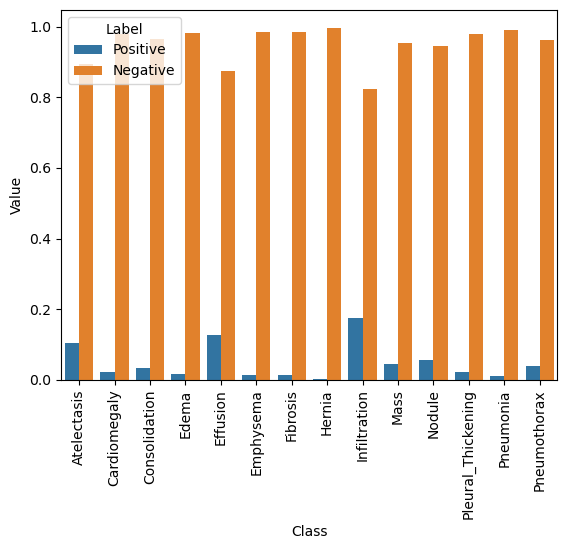

In [21]:
data = pd.DataFrame({"Class": labels_text, "Label": "Positive", "Value": freq_pos})
data = pd.concat([data, pd.DataFrame([{"Class": labels_text[l], "Label": "Negative", "Value": v} for l, v in enumerate(freq_neg)])], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

## Following assigning class weights

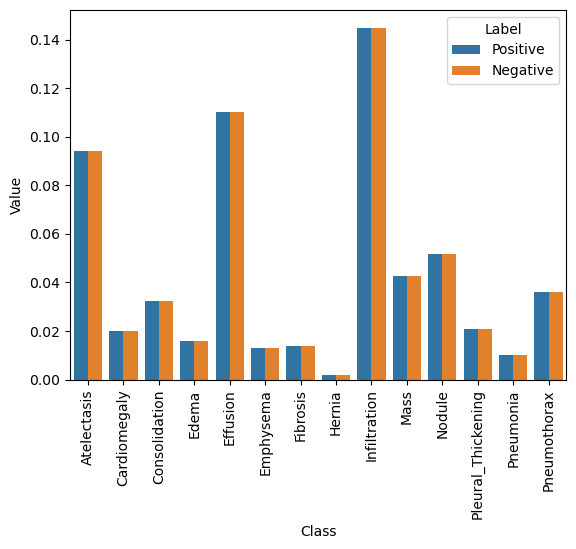

In [22]:
data = pd.DataFrame({"Class": labels_text, "Label": "Positive", "Value": pos_contribution})
# data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}
#                         for l,v in enumerate(neg_contribution)], ignore_index=True)
new_rows = pd.DataFrame([{"Class": labels_text[l], "Label": "Negative", "Value": v}
                         for l, v in enumerate(neg_contribution)])
data = pd.concat([data, new_rows], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

# Define Medical Statistics

Sensitivity 
-----------

If the patient has a disease, what's the probability that the model will identify it?

Specificity
-----------

If the patient is normal, what's the probabilty the model will say so 

Positive Predictive Value PPV
-----------------------------

If the model predicts positive, what is the probability the patient has the disease?

Negative Predictive Value NPV
-----------------------------

If the model predicts negative, what is the probability the patient is normal?

In [23]:
# Sensitivity (Recall / True Positive Rate)
# Specificity measures how well your model identifies the positives correctly.
sensitivity = tf.keras.metrics.Recall()

# Specificity (True Negative Rate)
# Specificity measures how well your model identifies the negatives correctly.
def specificity(y_test, y_pred):
    true_negatives = tf.reduce_sum(tf.cast((y_pred < 0.5) & (y_test == 0), tf.float32))
    possible_negatives = tf.reduce_sum(tf.cast(y_test == 0, tf.float32))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

# Prevalence refers to the proportion of positive cases in the dataset
def prevalence(y_test, y_pred):
    return tf.reduce_sum(y_test) / tf.cast(tf.size(y_test), tf.float32)

# Compile and fit the model

In [24]:
%%time

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              # loss=focal_loss(),
              # loss='binary_crossentropy',
              loss=get_weighted_loss(pos_weights, neg_weights),
              # loss=weighted_binary_crossentropy(class_weights),
              metrics=[sensitivity, specificity, 'auc'])

# -----------------------------------------------------------------------------------------------------

early_stopping = tf.keras.callbacks.EarlyStopping(
    verbose=1,
    monitor='val_loss',
    patience=15,
    mode='min',
    restore_best_weights=True)

# When fitting the model with PrintEveryNEpoch use verbose=0
from tensorflow_utils import PrintEveryNEpoch
periodic_messages = PrintEveryNEpoch(n=30, timezone_str='US/Mountain')


history = model.fit(
    
    #train_tf,         
    train_tf_with_weights, 
    
    verbose=0,
    epochs=50000,
    batch_size=batch_size,
    validation_data=valid_tf,
    callbacks=[early_stopping, periodic_messages])

I0000 00:00:1729702061.992698    8078 service.cc:146] XLA service 0x7f08d848e5e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729702061.992730    8078 service.cc:154]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2024-10-23 16:47:42.277980: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-23 16:47:44.220987: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-23 16:47:45.382414: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10310', 140 bytes spill stores, 140 bytes spill loads

I0000 00:00:1729702085.020047    8078 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-10-23 16:48:0


Epoch 1 (2024-10-23 10:48:45): 
auc = 0.5100, loss = 1.0443, recall = 0.5832, specificity = 0.4226, val_auc = 0.4875, val_loss = 1.0748, val_recall = 0.5556, val_specificity = 0.4258

Epoch 30 (2024-10-23 10:50:03): 
auc = 0.6470, loss = 0.8781, recall = 0.6327, specificity = 0.5503, val_auc = 0.4784, val_loss = 0.9981, val_recall = 0.3457, val_specificity = 0.6212

Epoch 60 (2024-10-23 10:51:24): 
auc = 0.6973, loss = 0.8337, recall = 0.6897, specificity = 0.6011, val_auc = 0.5292, val_loss = 0.9742, val_recall = 0.3951, val_specificity = 0.6634

Epoch 90 (2024-10-23 10:52:46): 
auc = 0.7398, loss = 0.7809, recall = 0.6927, specificity = 0.6559, val_auc = 0.5554, val_loss = 0.9679, val_recall = 0.3704, val_specificity = 0.7172

Epoch 120 (2024-10-23 10:54:08): 
auc = 0.7889, loss = 0.7432, recall = 0.7571, specificity = 0.6613, val_auc = 0.5848, val_loss = 0.9571, val_recall = 0.4074, val_specificity = 0.7503

Epoch 150 (2024-10-23 10:55:29): 
auc = 0.8056, loss = 0.7173, recall = 0.

# Print Loss Curves

	•	Recall (also known as sensitivity or true positive rate) is the percentage of all __actual__ positives in the dataset that were correctly identified by the model. 

	•	Precision is the percentage of the positive predictions made by the model that were actually correct. It measures how many of the predicted positives were true positives.

In [25]:
history.history.keys()

dict_keys(['auc', 'loss', 'recall', 'specificity', 'val_auc', 'val_loss', 'val_recall', 'val_specificity'])

In [26]:
losses_list=['loss', 'get_weighted_loss', 'auc']

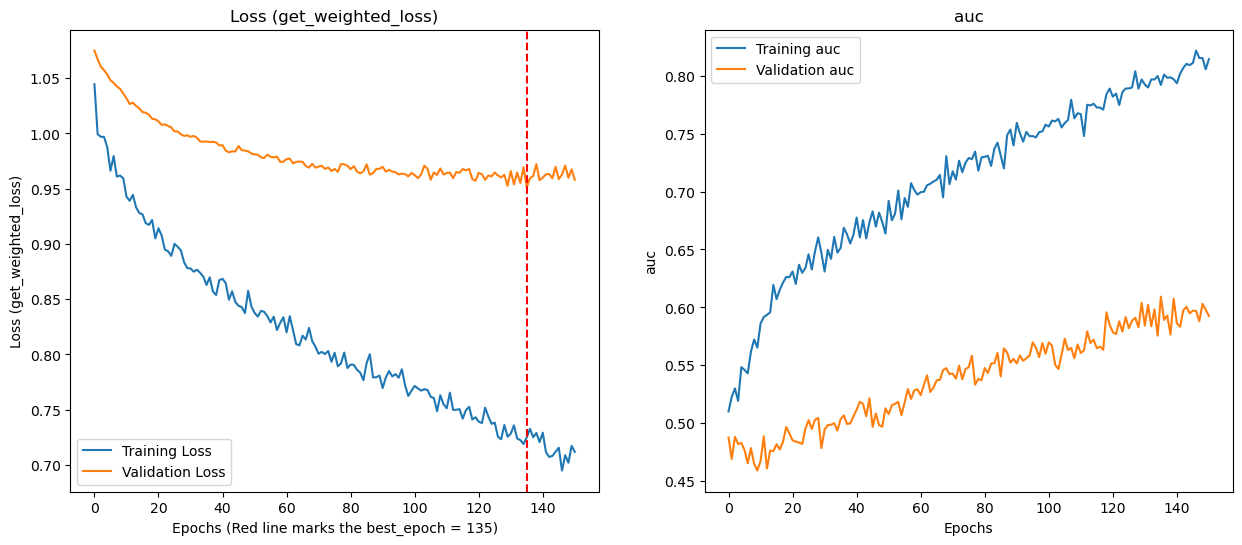

In [27]:
from tensorflow_utils import loss_curves

loss_curves(history, start_after=0, losses=losses_list, best_epoch=early_stopping.best_epoch)

# Test set evaluation

In [28]:
model_eval = model.evaluate(test_tf)

6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - auc: 0.4955 - loss: 1.8837 - recall: 0.3009 - specificity: 0.7015

2024-10-23 16:55:35.155180: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3669', 16 bytes spill stores, 16 bytes spill loads

2024-10-23 16:55:35.207334: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3669', 172 bytes spill stores, 172 bytes spill loads



7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - auc: 0.4948 - loss: 1.8956 - recall: 0.3027 - specificity: 0.6959 


In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Get the predicted probabilities from the model
y_pred_probs = model.predict(X_test)

auc_max        = 0
auc_max_thresh = 0
f1_max         = 0
f1_max_thresh  = 0

sensitivity_max        = 0
sensitivity_max_thresh = 0
specificity_max        = 0
specificity_max_thresh = 0
PPV_max        = 0
PPV_max_thresh = 0
NPV_max        = 0
NPV_max_thresh = 0

for y_pred_thresh_gt in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
    
    # Apply the threshold to the predictions
    y_pred_threshold = tf.cast(y_pred_probs > y_pred_thresh_gt, tf.float32)
    
    # Convert y_pred_threshold to NumPy if needed for evaluation (depending on your workflow)
    y_pred_threshold = y_pred_threshold.numpy()
    
    # Assuming you have true labels for X_test in 'y_test'
    # Use zero_division to handle cases where no positive predictions are made
    # precision = precision_score(y_test, y_pred_threshold, average='macro', zero_division=0)
    # recall    = recall_score(y_test, y_pred_threshold, average='macro', zero_division=0)
    f1        = f1_score(y_test, y_pred_threshold, average='macro', zero_division=0)
    if f1 >= f1_max:
        f1_max        = f1
        f1_max_thresh = y_pred_thresh_gt
    
    # Sensitivity (Recall) with 'macro' averaging
    sensitivity = recall_score(y_test, y_pred_threshold, average='macro')
    recall      = sensitivity
    if sensitivity >= sensitivity_max:
        sensitivity_max        = sensitivity
        sensitivity_max_thresh = y_pred_thresh_gt
    
    # Specificity (requires confusion matrix for each label)
    tn, fp, fn, tp = confusion_matrix(y_test.ravel(), y_pred_threshold.ravel()).ravel()
    specificity = tn / (tn + fp)
    if specificity >= specificity_max:
        specificity_max        = specificity
        specificity_max_thresh = y_pred_thresh_gt

    if (tp + fp) == 0:
        PPV = np.nan
    else:
        PPV       = tp / (tp + fp)
    precision = PPV
    if PPV >= PPV_max:
        PPV_max        = PPV
        PPV_max_thresh = y_pred_thresh_gt

    if (tn + fn) == 0:
        NPV = np.nan
    else:
        NPV = tn / (tn + fn)
    if NPV >= NPV_max:
        NPV_max        = NPV
        NPV_max_thresh = y_pred_thresh_gt
    
    # Prevalence (percentage of positive cases in y_test)
    prevalence = np.sum(y_test) / np.size(y_test)
    
    auc       = roc_auc_score(y_test, y_pred_threshold, average='macro')
    if auc >= auc_max:
        auc_max        = auc
        auc_max_thresh = y_pred_thresh_gt
    
    print(f"y_pred_threshold > {y_pred_thresh_gt:>5} Sensitivity: {sensitivity:.04f} Specificity: {specificity :.04f} PPV: {PPV :.04f} NPV: {NPV :.04f} AUC: {auc:.04f} F1: {f1:.04f}")

print(f"\n{f1_max  = :.04f}  {f1_max_thresh = :.04f}")
print(f"{auc_max = :.04f} {auc_max_thresh = :.04f}\n")

print(f"{sensitivity_max = :.04f} {sensitivity_max_thresh = :.04f}")
print(f"{specificity_max = :.04f} {specificity_max_thresh = :.04f}\n")

print(f"{PPV_max = :.04f} {PPV_max_thresh = :.04f}")
print(f"{NPV_max = :.04f} {NPV_max_thresh = :.04f}\n")

2024-10-23 16:55:52.168050: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3372', 140 bytes spill stores, 140 bytes spill loads



14/14 ━━━━━━━━━━━━━━━━━━━━ 25s 771ms/step
y_pred_threshold >   0.1 Sensitivity: 0.9987 Specificity: 0.0035 PPV: 0.1310 NPV: 0.9474 AUC: 0.5011 F1: 0.2316
y_pred_threshold >  0.15 Sensitivity: 0.9782 Specificity: 0.0188 PPV: 0.1304 NPV: 0.8496 AUC: 0.4985 F1: 0.2299
y_pred_threshold >   0.2 Sensitivity: 0.9428 Specificity: 0.0585 PPV: 0.1309 NPV: 0.8717 AUC: 0.5007 F1: 0.2295
y_pred_threshold >  0.25 Sensitivity: 0.8792 Specificity: 0.1143 PPV: 0.1301 NPV: 0.8639 AUC: 0.4967 F1: 0.2255
y_pred_threshold >   0.3 Sensitivity: 0.8009 Specificity: 0.1892 PPV: 0.1296 NPV: 0.8642 AUC: 0.4950 F1: 0.2211
y_pred_threshold >  0.35 Sensitivity: 0.6893 Specificity: 0.2798 PPV: 0.1261 NPV: 0.8573 AUC: 0.4845 F1: 0.2110
y_pred_threshold >   0.4 Sensitivity: 0.5860 Specificity: 0.4011 PPV: 0.1284 NPV: 0.8657 AUC: 0.4936 F1: 0.2079
y_pred_threshold >  0.45 Sensitivity: 0.4540 Specificity: 0.5463 PPV: 0.1308 NPV: 0.8692 AUC: 0.5002 F1: 0.2009
y_pred_threshold >   0.5 Sensitivity: 0.3086 Specificity: 0.67

### decide which threshold to use

In [38]:
y_pred_thresh_gt = 0.50
y_pred_threshold = tf.cast(y_pred_probs > y_pred_thresh_gt, tf.float32)
y_pred_threshold = y_pred_threshold.numpy()

### confusion matrixes

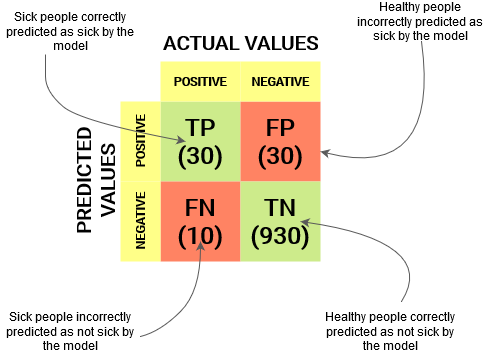

Confusion Matrix for each label:

Confusion matrix for Atelectasis:
[[230 130]
 [ 33  27]]


Confusion matrix for Cardiomegaly:
[[238 132]
 [ 31  19]]


Confusion matrix for Consolidation:
[[241 126]
 [ 29  24]]


Confusion matrix for Edema:
[[237 133]
 [ 36  14]]


Confusion matrix for Effusion:
[[228 139]
 [ 40  13]]


Confusion matrix for Emphysema:
[[313  51]
 [ 51   5]]


Confusion matrix for Fibrosis:
[[280  79]
 [ 49  12]]


Confusion matrix for Hernia:
[[217 153]
 [ 30  20]]


Confusion matrix for Infiltration:
[[222 139]
 [ 40  19]]


Confusion matrix for Mass:
[[260 100]
 [ 42  18]]


Confusion matrix for Nodule:
[[261 105]
 [ 42  12]]


Confusion matrix for Pleural_Thickening:
[[220 142]
 [ 35  23]]


Confusion matrix for Pneumonia:
[[268 102]
 [ 38  12]]


Confusion matrix for Pneumothorax:
[[256 109]
 [ 36  19]]




In [39]:
from IPython.display import Image
from IPython.display import display

# Path to the image file
img_path = "../../imgs/Example-Confusion-matrix.png"

# Display the image
display(Image(filename=img_path))

from sklearn.metrics import multilabel_confusion_matrix

# Calculate confusion matrix for each label
conf_matrix = multilabel_confusion_matrix(y_test, y_pred_threshold)

# Print the confusion matrix for each label
print("Confusion Matrix for each label:\n")
for i, label in enumerate(labels_text):
    print(f"Confusion matrix for {label}:")
    print(conf_matrix[i])
    print("\n")

In [40]:
# Generate detailed classification report
report = sklearn.metrics.classification_report(y_test, y_pred_threshold, zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       0.17      0.45      0.25        60
           1       0.13      0.38      0.19        50
           2       0.16      0.45      0.24        53
           3       0.10      0.28      0.14        50
           4       0.09      0.25      0.13        53
           5       0.09      0.09      0.09        56
           6       0.13      0.20      0.16        61
           7       0.12      0.40      0.18        50
           8       0.12      0.32      0.18        59
           9       0.15      0.30      0.20        60
          10       0.10      0.22      0.14        54
          11       0.14      0.40      0.21        58
          12       0.11      0.24      0.15        50
          13       0.15      0.35      0.21        55

   micro avg       0.13      0.31      0.18       769
   macro avg       0.12      0.31      0.17       769
weighted avg       0.13      0.31      0.18       769
 samples avg       0.10   

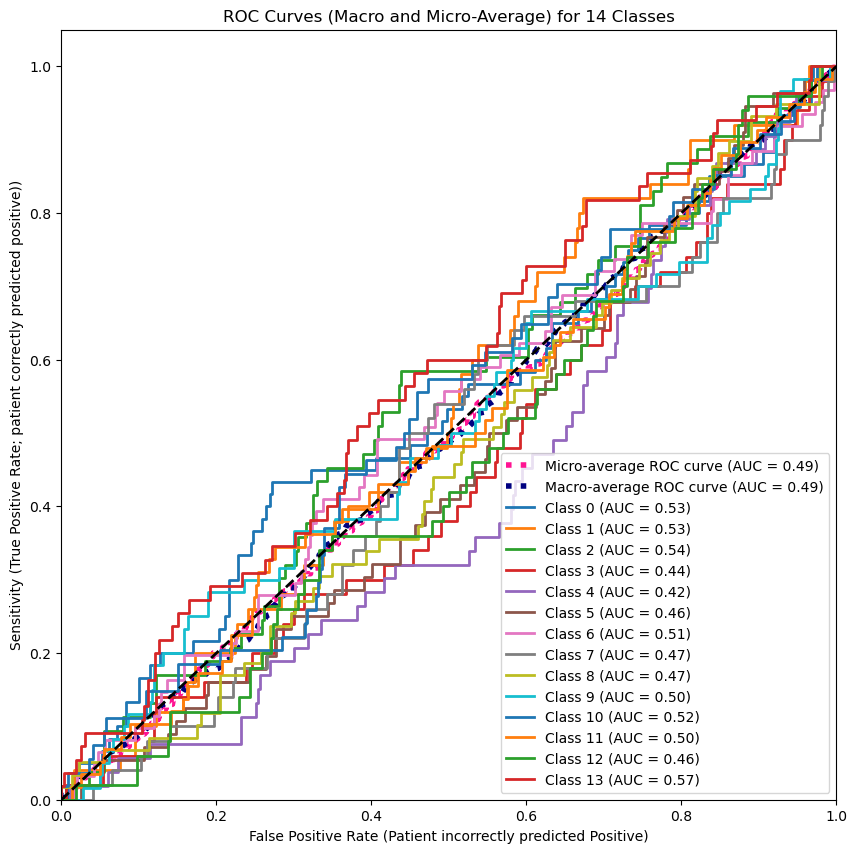

In [41]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming you have y_test (true labels) and y_pred_probs (predicted probabilities)
n_classes = y_test.shape[1]  # Number of classes (14 in your case)

# Binarize the output labels if they aren't already
y_test_binarized = label_binarize(y_test, classes=[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_probs.ravel())
roc_auc["micro"]              = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC AUC
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"]     = all_fpr
tpr["macro"]     = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})', color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})', color='navy', linestyle=':', linewidth=4)

# Plot ROC curve for each class
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Plot configuration
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Patient incorrectly predicted Positive)')
plt.ylabel('Sensitivity (True Positive Rate; patient correctly predicted positive))')
plt.title('ROC Curves (Macro and Micro-Average) for 14 Classes')
plt.legend(loc="lower right")
plt.show()

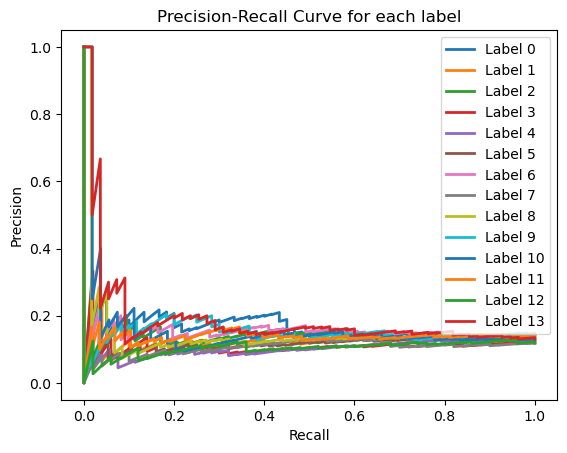

In [42]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Assuming y_test is your true labels and y_pred_probs is the predicted probabilities for each class
n_classes = y_test.shape[1]  # Get the number of labels (columns)

# Loop through each label
for i in range(n_classes):
    precision, recall, thresholds = precision_recall_curve(y_test[:, i], y_pred_probs[:, i])
    
    plt.plot(recall, precision, lw=2, label=f'Label {i}')
    
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for each label')
plt.legend(loc='best')
plt.show()

# Calibration

When performing classification we often want not only to predict the class label, but also obtain a probability of each label. This probability would ideally give us some kind of confidence on the prediction. In order to observe how our model's generated probabilities are aligned with the real probabilities, we can plot what's called a *calibration curve*. 

In order to generate a calibration plot, we first bucketize our predictions to a fixed number of separate bins (e.g. 5) between 0 and 1. We then calculate a point for each bin: the x-value for each point is the mean for the probability that our model has assigned to these points and the y-value for each point fraction of true positives in that bin. We then plot these points in a linear plot. A well-calibrated model has a calibration curve that almost aligns with the y=x line.

The `sklearn` library has a utility `calibration_curve` for generating a calibration plot. Let's use it and take a look at our model's calibration:

In [43]:
from sklearn.calibration import calibration_curve
def plot_calibration_curve(y, pred):
    plt.figure(figsize=(20, 20))
    for i in range(len(labels_text)):
        plt.subplot(4, 4, i + 1)
        fraction_of_positives, mean_predicted_value = calibration_curve(y[:,i], pred[:,i], n_bins=20)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.plot(mean_predicted_value, fraction_of_positives, marker='.')
        plt.xlabel("Predicted Value")
        plt.ylabel("Fraction of Positives")
        plt.title(labels_text[i])
    plt.tight_layout()
    plt.show()

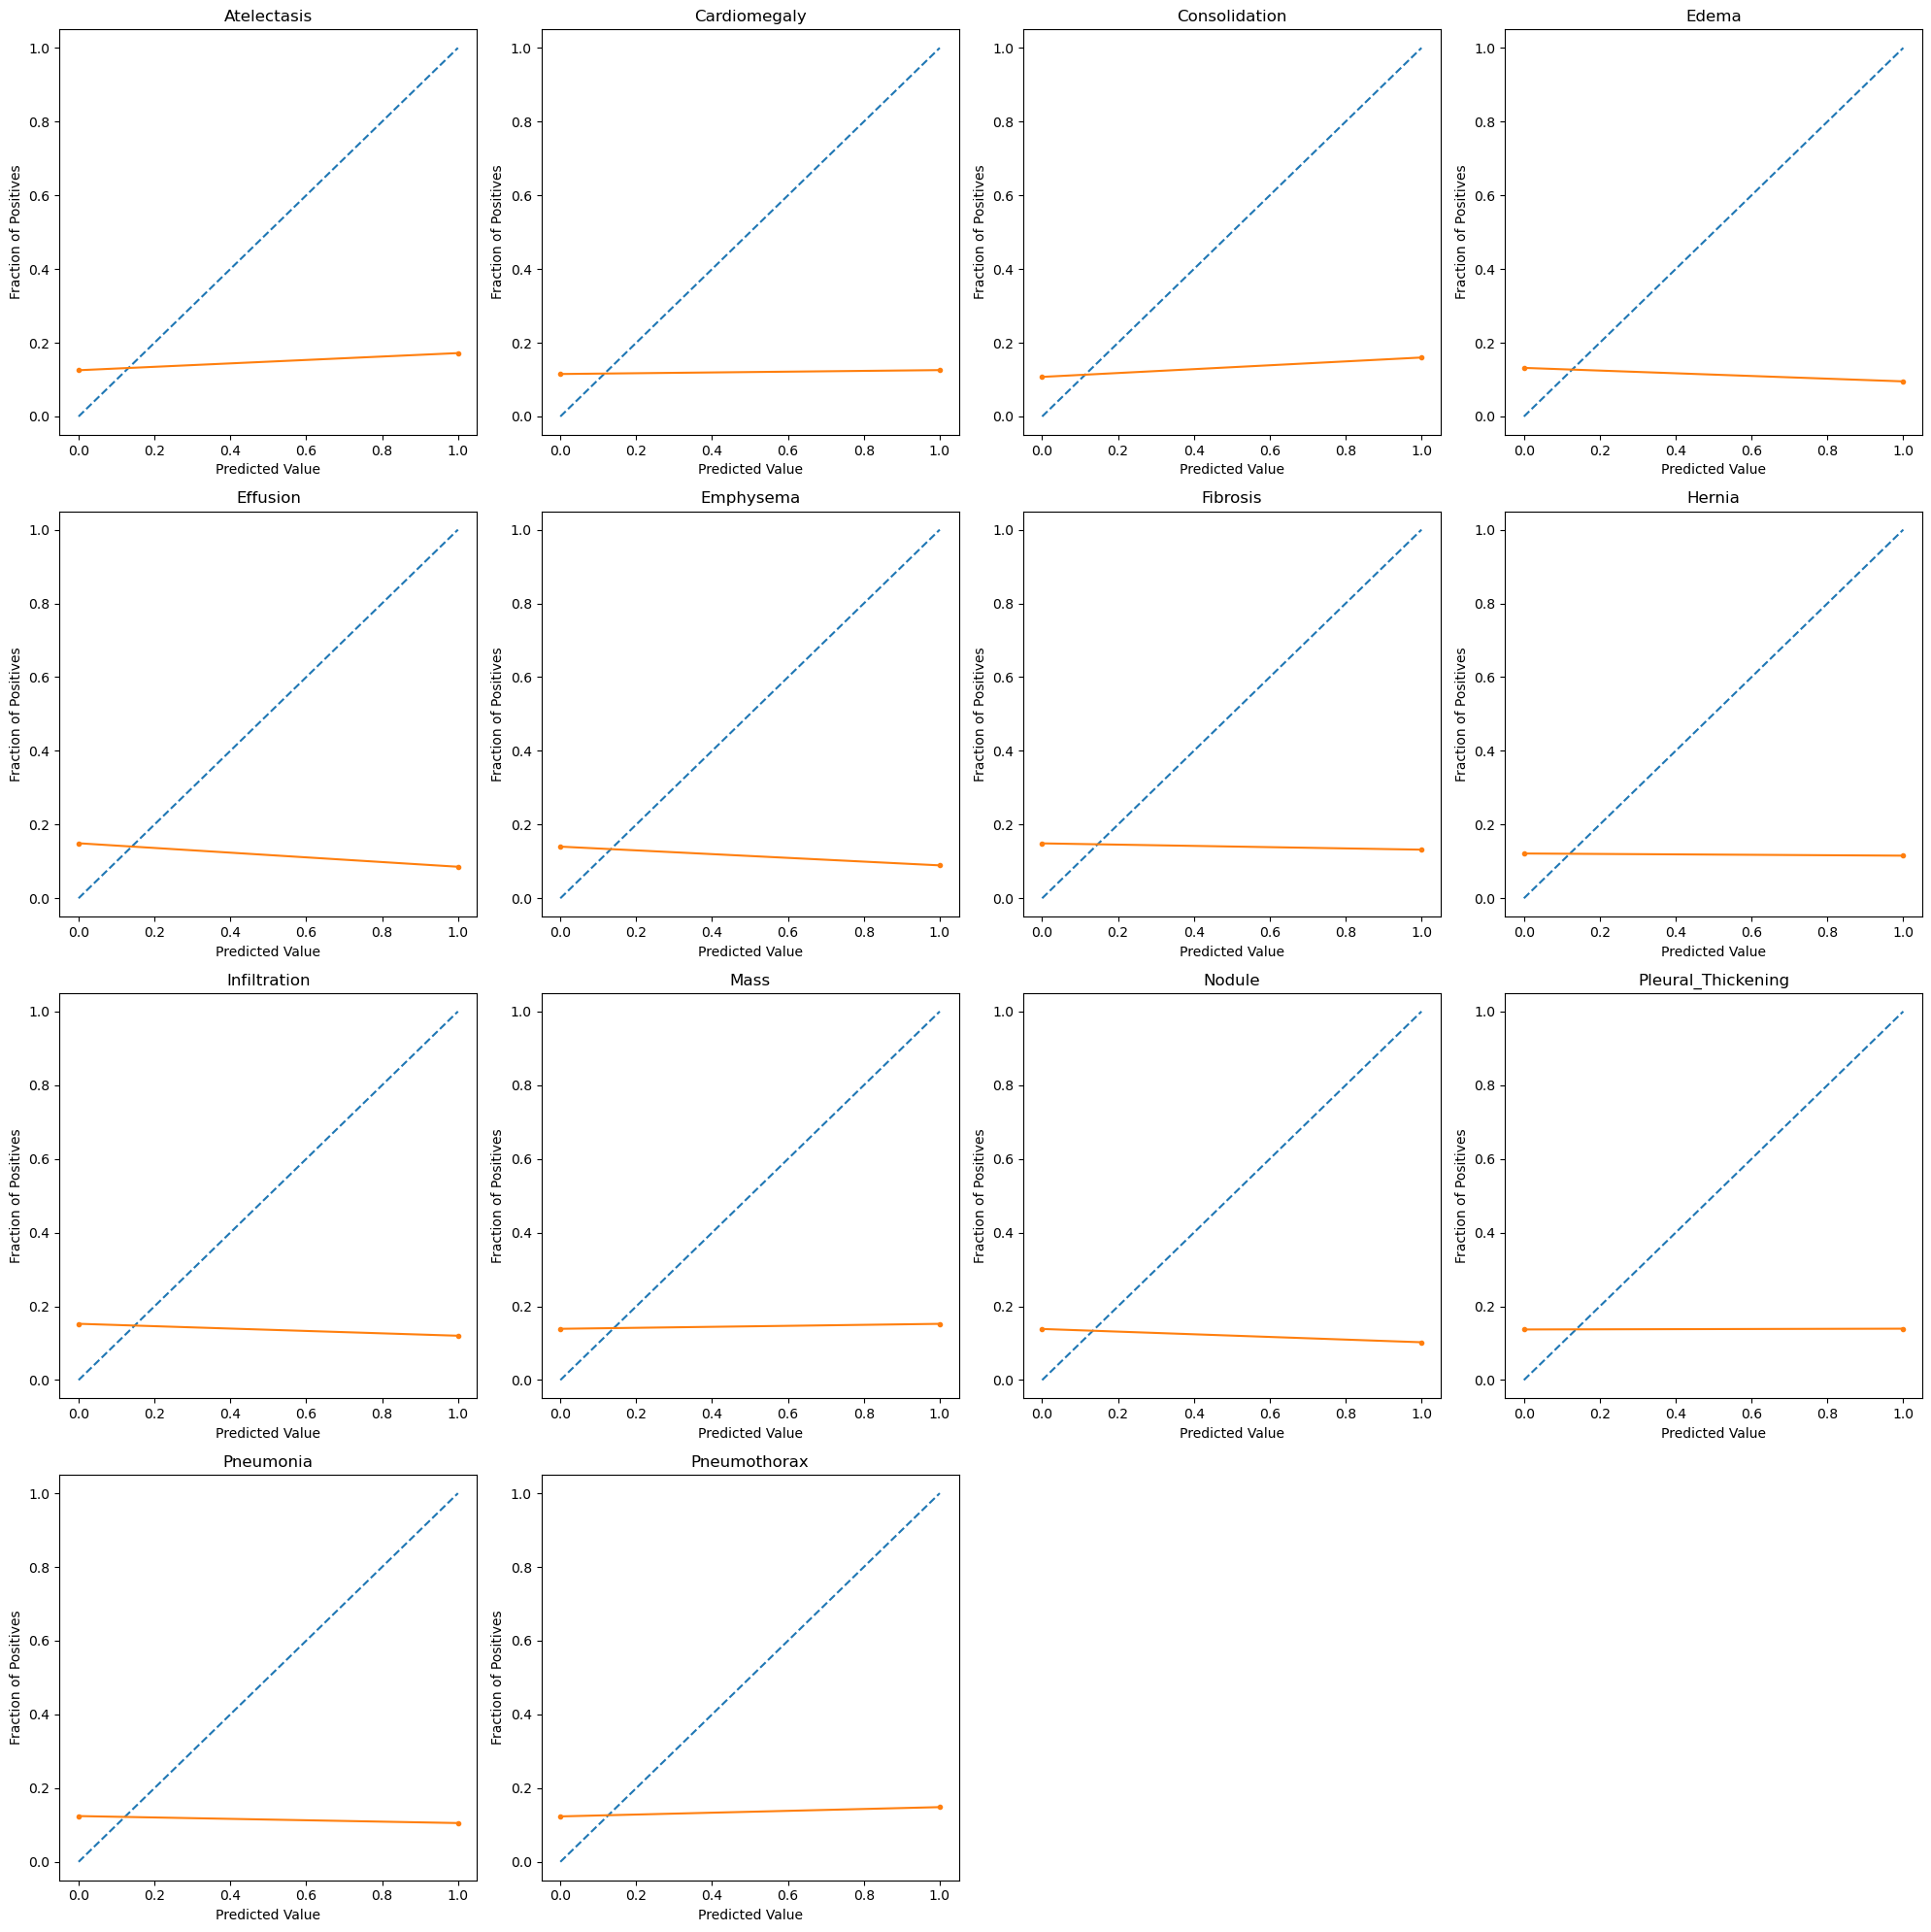

In [44]:
plot_calibration_curve(y_test, y_pred_threshold)

As the above plots show, for most predictions our model's calibration plot does not resemble a well calibrated plot. How can we fix that?...

Thankfully, there is a very useful method called [Platt scaling](https://en.wikipedia.org/wiki/Platt_scaling) which works by fitting a logistic regression model to our model's scores. To build this model, we will be using the training portion of our dataset to generate the linear model and then will use the model to calibrate the predictions for our test portion.

# I don't understand where the values for train_results come from